# 引入库

In [1]:
import keras
import os
import json
import shutil
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from mylibs.ProcessBar import ShowProcess
from mylibs import funs
from mylibs.my_contrib import *
keras.__version__

Using TensorFlow backend.


'2.2.4'

# 猫狗分类实验
## 实验目的
创建一个简单图像二分类的卷积模型,掌握以下知识点：
* 数据生成器的使用方法
    ./MyDL/Tensorflow/demo/python/demo_ImageDataGenerator2.py
* 卷积神经网络模型创建：卷积层，密度层，激活函数，损失函数，优化函数
* 模型训练方法
* 模型预测方法
* plt基本使用方法
* 训练曲线绘制
* 可视化FeatureMap
* 可视化神经网络的过滤器
* 可视化类激活的热力图

本实验的数据将作为基础参考

## 实验数据说明
  * 网络数据下载地址：https://www.kaggle.com/c/dogs-vs-cats/data
  * 本地数据存储路径：~/e/dataset_tiptical/cats_and_dogs
  * 实验数据根目录：~/data/cats_and_dogs
      - ./ori      ------------猫狗分类原始数据目录
      - ./lab_base ------------实验方案目录
      - ./lab_base/train ------训练目录
      - ./lab_base/valid ------校验目录
      - ./lab_base/test  ------测试目录
      - ./lab_base/test.jpg ---测试图片
      

## 参考资料
visualization of filters keras 基于Keras的卷积神经网络（CNN）可视化

http://www.cnblogs.com/bnuvincent/p/9612686.html

python深度学习{eep learning with python中文版.pdf}源码

https://github.com/fchollet/deep-learning-with-python-notebooks

数据下载：

https://www.kaggle.com/c/dogs-vs-cats/data

本地数据

~/e/dataset_tiptical/cats_and_dogs


# 实验2
在实验1基础上增加Dropout层

## 实验参数

In [2]:
##实验参数
print('\n==============================================')
print('设置实验参数')
data_path='%s/data/cats_and_dogs'%(os.getenv('HOME')) #猫狗分类数据根目录
ori_path='%s/ori'%(data_path)                         #猫狗分类原始文件目录
lab_path='%s/lab_2'%(data_path)                       #实验方案目录
split_num="0.6,0.2,0.2"                               #实验数据分割方案,<1：比例分割，>1：数量分割
batch_size=32                                         #批量大小
data_enhance=False                                    #ImageDataGenerator数据启用数据增强
epochs=100                                            #训练轮次
img_width=150                                         #训练图像宽度
img_height=150                                        #训练图像高度 
test_img_path='%s/test.jpg'%(data_path)               #测试图片路径
images_per_row=16       #图像显示每行显示的单元个数
#feature_map_top_num=12  #FeatureMap前面N层{include_top=False}
img_margin=3            #图像单元空隙
layers_name=['conv2d_1','conv2d_2','conv2d_3','conv2d_4'] #卷积层名称
#layers_name=['conv2d_1'] #卷积层名称
last_conv_layer_name='conv2d_4' #最后一层卷积层
gen_pat_steps=40        #构造迭代次数


设置实验参数


## 加载数据

In [3]:
##加载数据
print('\n==============================================')
print('加载数据......')
#删除lab_path
shutil.rmtree(lab_path) if os.path.exists(lab_path) else ''
#数据生成器
(train_gen,valid_gen,test_gen)=DataGen(ori_path,lab_path,split_num
                                       ,img_width=img_width,img_height=img_height
                                       ,batch_size=batch_size,enhance=data_enhance)


加载数据......
Found 15000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## 创建网络

In [4]:
##构建网络
print('\n==============================================')
print('构建网络')
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(img_height, img_width, 3),name='conv2d_1'))
model.add(layers.MaxPooling2D((2, 2),name='max_pooling2d_1'))
model.add(layers.core.Dropout(0.5))
model.add(layers.Conv2D(64, (3, 3), activation='relu',name='conv2d_2'))
model.add(layers.MaxPooling2D((2, 2),name='max_pooling2d_2'))
model.add(layers.core.Dropout(0.5))
model.add(layers.Conv2D(128, (3, 3), activation='relu',name='conv2d_3'))
model.add(layers.MaxPooling2D((2, 2),name='max_pooling2d_3'))
model.add(layers.core.Dropout(0.5))
model.add(layers.Conv2D(128, (3, 3), activation='relu',name='conv2d_4'))
model.add(layers.MaxPooling2D((2, 2),name='max_pooling2d_4'))
model.add(layers.core.Dropout(0.5))
model.add(layers.Flatten(name='flatten_1'))
model.add(layers.Dense(512, activation='relu',name='dense_1'))
model.add(layers.Dense(1, activation='sigmoid',name='dense_2'))    
#打印模型
model.summary()
#模型编译
model.compile(loss='binary_crossentropy',
          optimizer=optimizers.RMSprop(lr=1e-4),
          metrics=['acc'])


构建网络
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
____

## 网络训练

In [5]:
##网络训练
print('\n==============================================')
print('网络训练 ......')
history = model.fit_generator(
  train_gen,
  steps_per_epoch=np.ceil(train_gen.samples/batch_size),
  epochs=epochs,
  validation_data=valid_gen,
  validation_steps=50)


网络训练 ......
Epoch 1/100
469/469 [==============================] - 28s 60ms/step - loss: 0.7009 - acc: 0.5283 - val_loss: 0.6922 - val_acc: 0.5069
Epoch 2/100
469/469 [==============================] - 27s 57ms/step - loss: 0.6697 - acc: 0.5715 - val_loss: 0.6850 - val_acc: 0.5413
Epoch 3/100
469/469 [==============================] - 25s 53ms/step - loss: 0.6342 - acc: 0.6272 - val_loss: 0.6644 - val_acc: 0.5837
Epoch 4/100
469/469 [==============================] - 25s 52ms/step - loss: 0.5946 - acc: 0.6724 - val_loss: 0.6724 - val_acc: 0.5768
Epoch 5/100
469/469 [==============================] - 24s 52ms/step - loss: 0.5684 - acc: 0.6967 - val_loss: 0.6425 - val_acc: 0.6356
Epoch 6/100
469/469 [==============================] - 24s 52ms/step - loss: 0.5537 - acc: 0.7111 - val_loss: 0.7172 - val_acc: 0.5806
Epoch 7/100
469/469 [==============================] - 25s 52ms/step - loss: 0.5430 - acc: 0.7158 - val_loss: 0.7143 - val_acc: 0.6022
Epoch 8/100
469/469 [=====================

Epoch 61/100
469/469 [==============================] - 25s 52ms/step - loss: 0.2799 - acc: 0.8837 - val_loss: 0.4241 - val_acc: 0.8331
Epoch 62/100
469/469 [==============================] - 27s 58ms/step - loss: 0.2759 - acc: 0.8856 - val_loss: 0.3390 - val_acc: 0.8631
Epoch 63/100
469/469 [==============================] - 25s 53ms/step - loss: 0.2816 - acc: 0.8842 - val_loss: 0.3763 - val_acc: 0.8541
Epoch 64/100
469/469 [==============================] - 27s 57ms/step - loss: 0.2764 - acc: 0.8866 - val_loss: 0.3483 - val_acc: 0.8612
Epoch 65/100
469/469 [==============================] - 27s 57ms/step - loss: 0.2758 - acc: 0.8826 - val_loss: 0.3568 - val_acc: 0.8669
Epoch 66/100
469/469 [==============================] - 27s 57ms/step - loss: 0.2726 - acc: 0.8887 - val_loss: 0.3726 - val_acc: 0.8515
Epoch 67/100
469/469 [==============================] - 27s 58ms/step - loss: 0.2726 - acc: 0.8859 - val_loss: 0.3812 - val_acc: 0.8406
Epoch 68/100
469/469 [==========================

## 保存模型

In [6]:
##保存模型
print('\n==============================================')
print('保存模型 ......') 
save_model(model,lab_path,train_gen.class_indices)


保存模型 ......


## 网络测试

In [7]:
print('\n==============================================')
print('网络测试 ......')
preds=model.predict_generator(
    test_gen, 
    steps=None, #预测轮数
    max_queue_size=32, 
    workers=1, 
    use_multiprocessing=False, 
    verbose=1)
#准确率计算
preds_acc_val=preds_acc(preds,test_gen)
print('准确率:%s'%(preds_acc_val))
preds_result_val=preds_result(preds,test_gen)
#print('预测值:%s'%(preds_result_val))


网络测试 ......
157/157 [==============================] - 7s 45ms/step
准确率:0.492


## 训练曲线


训练曲线


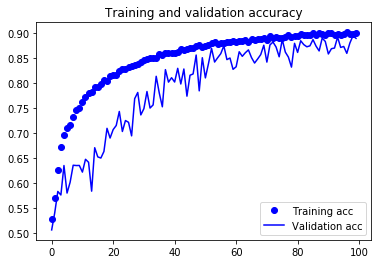

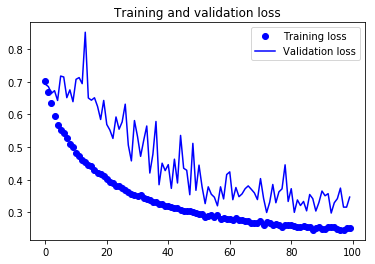

In [8]:
##训练曲线
print('\n==============================================')
print('训练曲线')
visualizer_scalar(history)

## 可视化FeatureMap


可视化FeatureMap


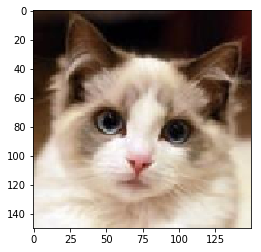

/home/hjw/MyDL/Tensorflow/mylibs/my_contrib.py:279: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


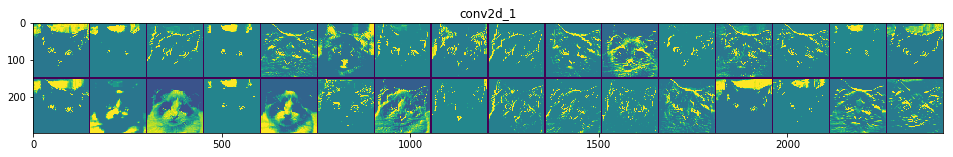

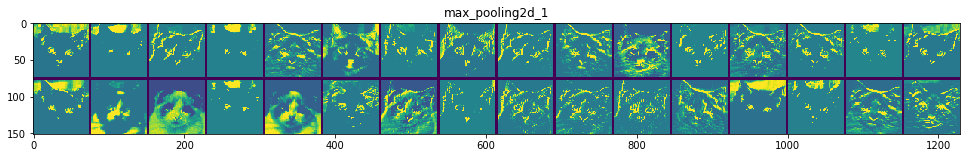

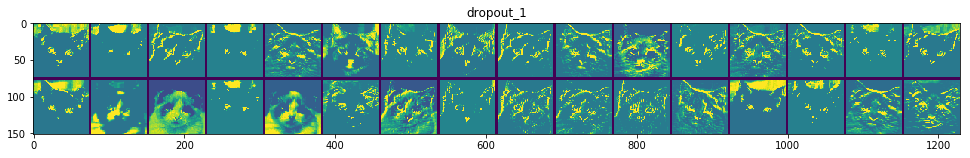

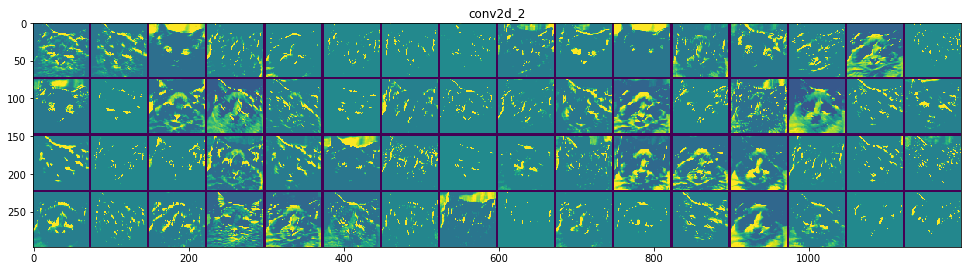

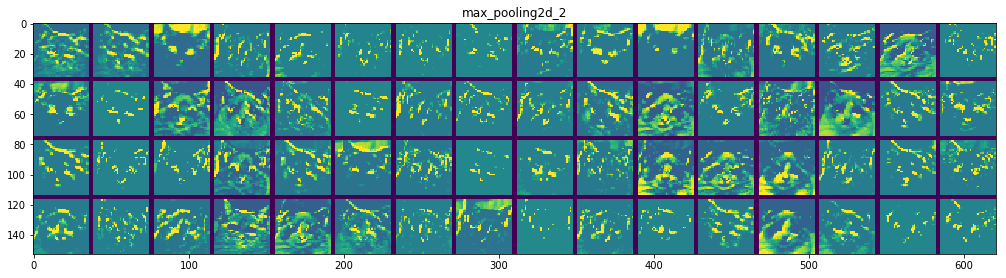

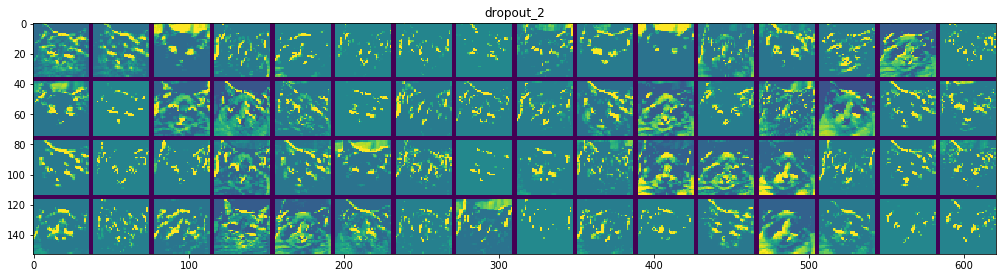

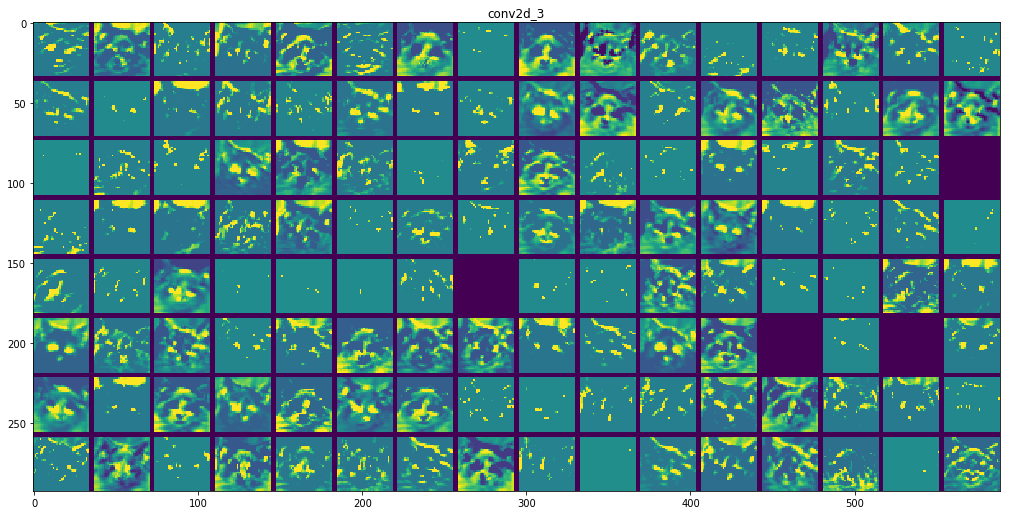

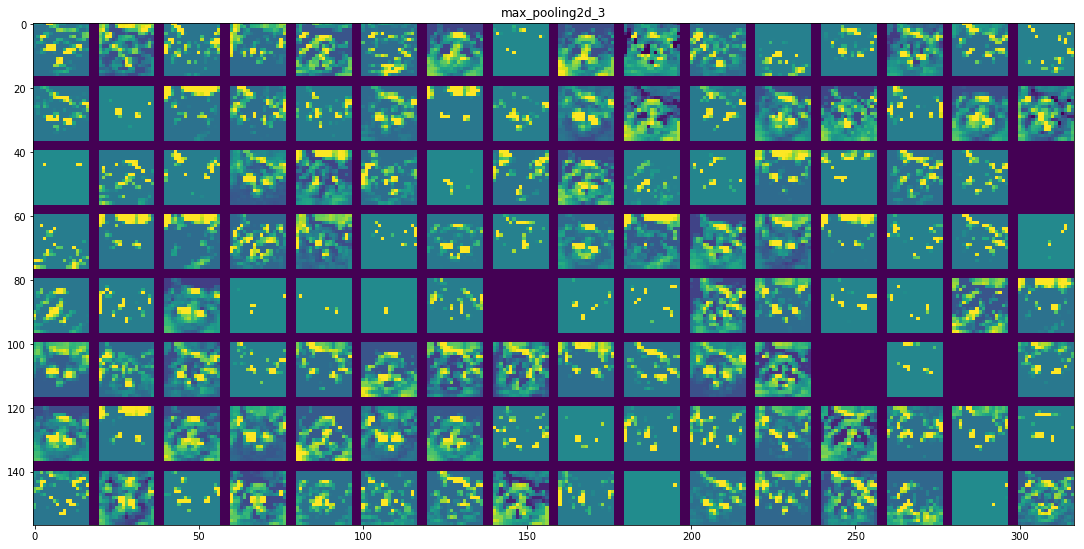

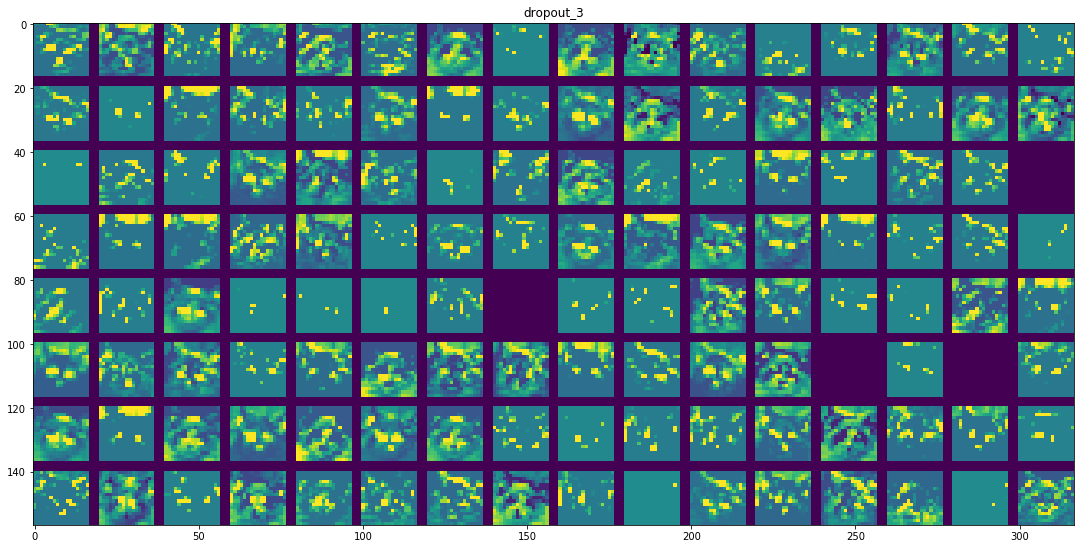

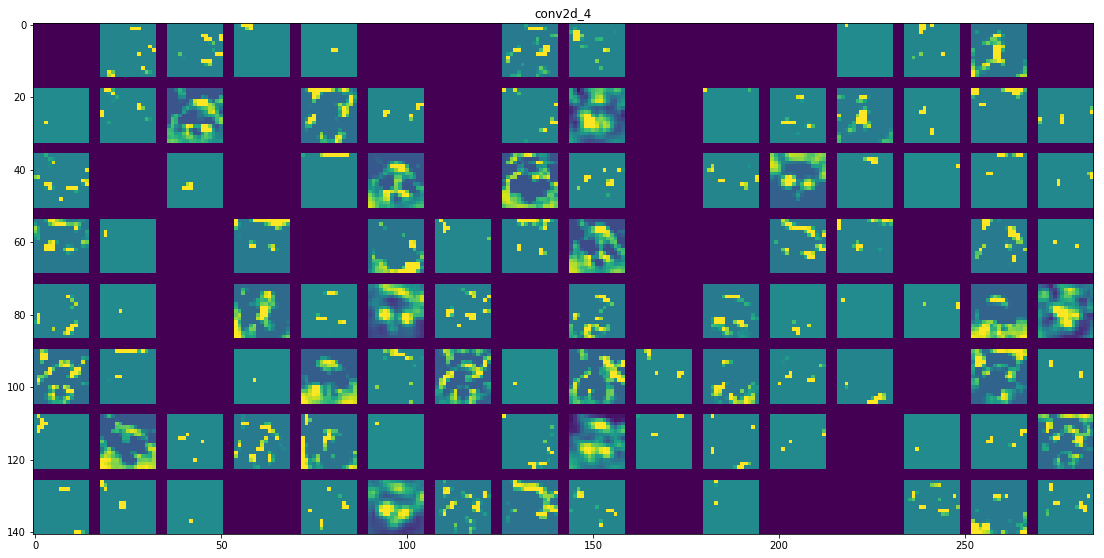

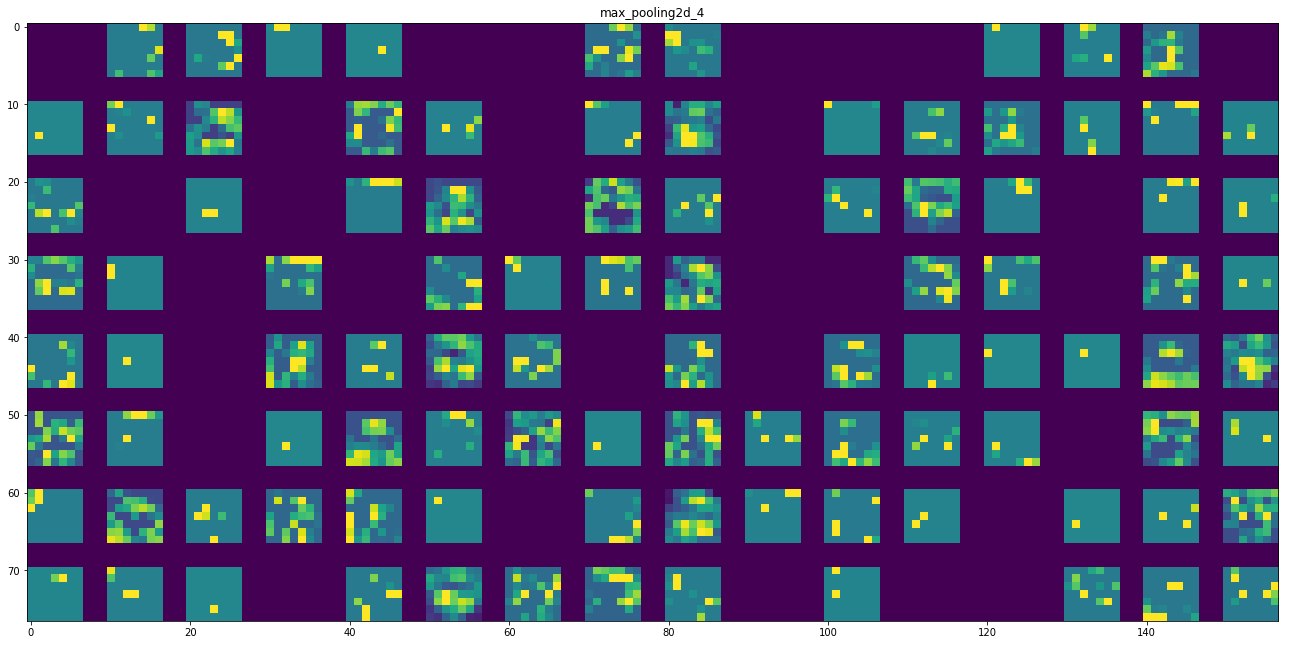

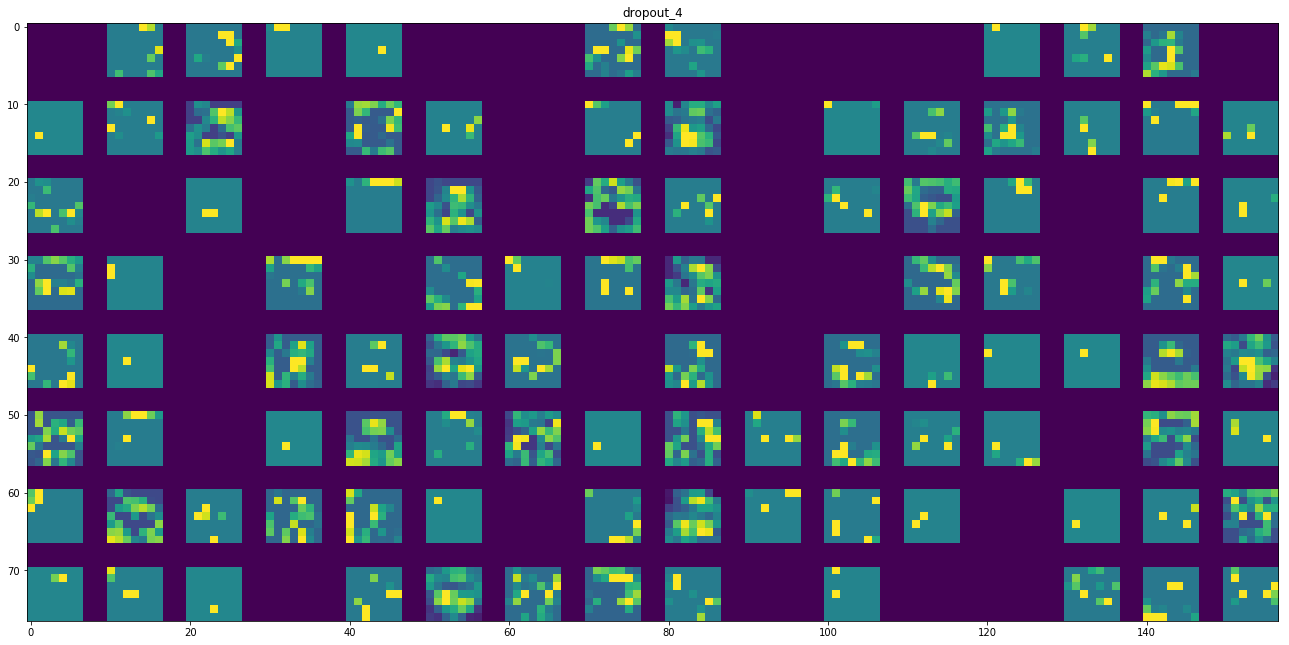

In [9]:
##可视化FeatureMap
print('\n==============================================')
print('可视化FeatureMap')
visualizer_feature_map(model,test_img_path,target_size=(img_height,img_width)
                       ,images_per_row=images_per_row,img_margin=img_margin)

## 可视化网络过滤器


可视化网络过滤器
Generating layer of conv2d_1 ......
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]
Done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


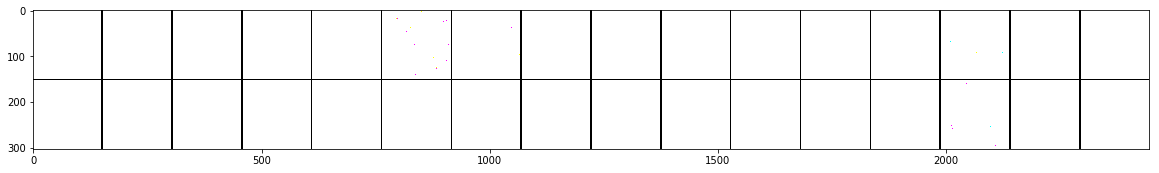

Generating layer of conv2d_2 ......


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done


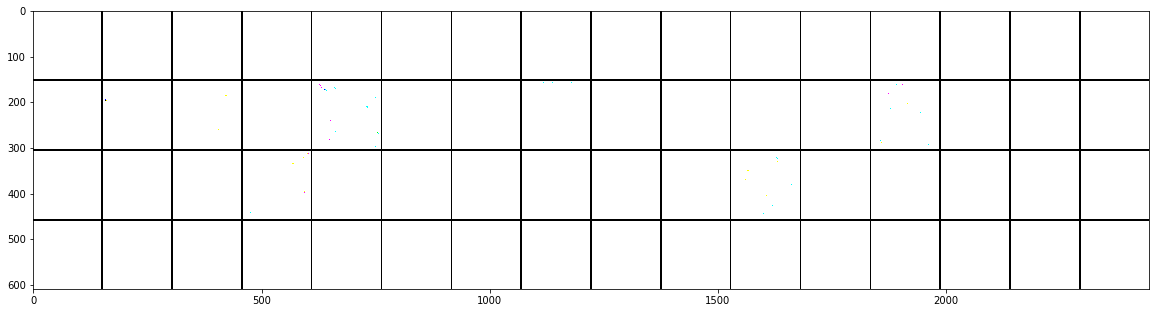

Generating layer of conv2d_3 ......


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done


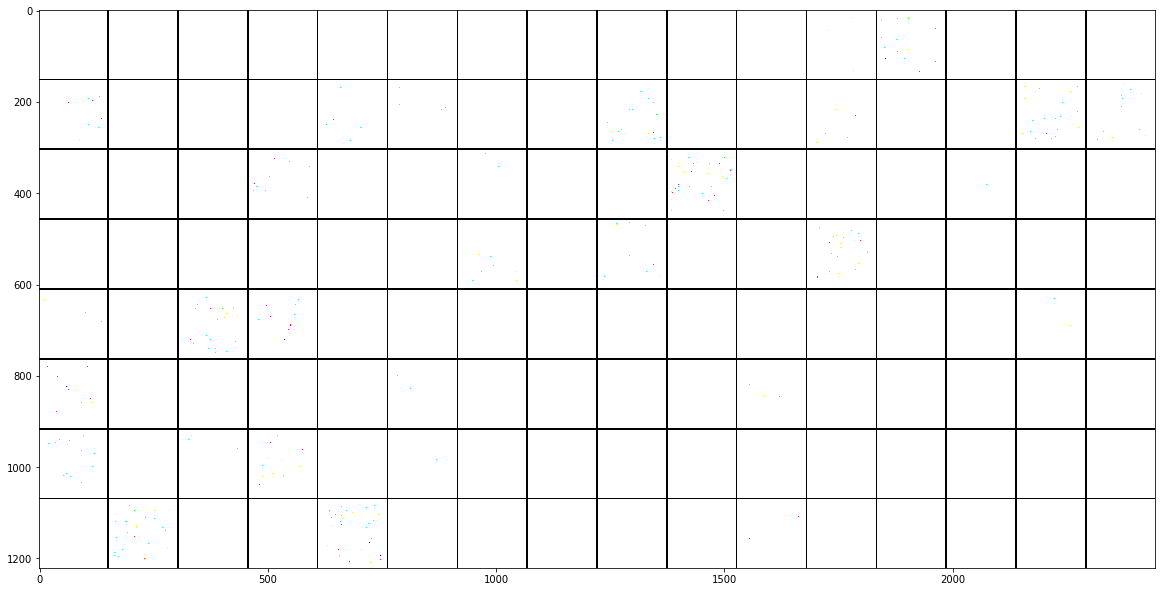

Generating layer of conv2d_4 ......


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done


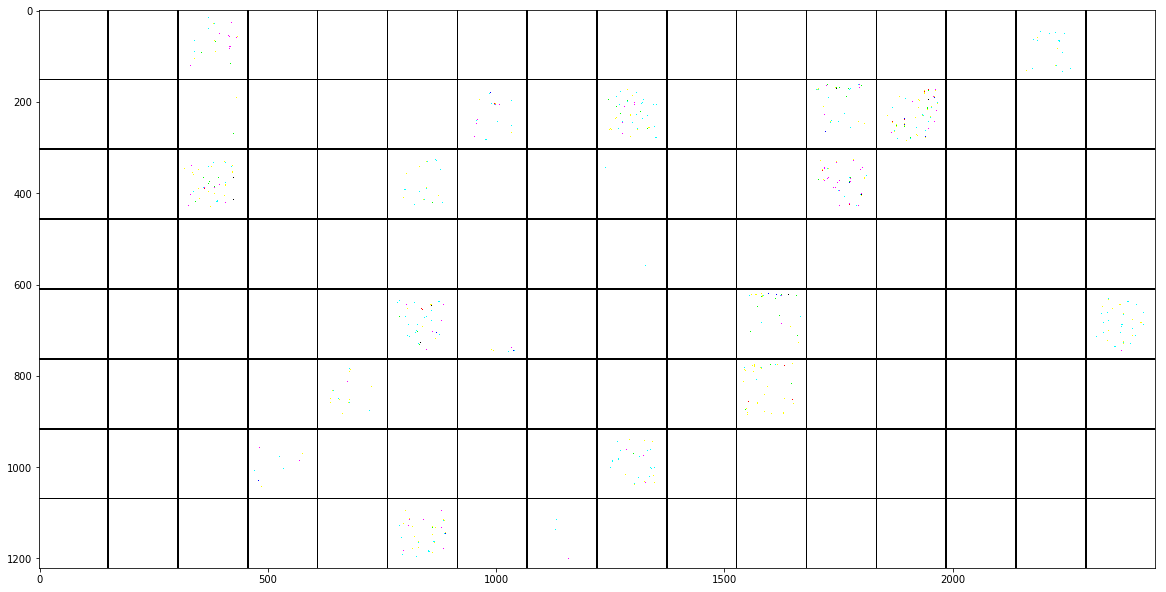

In [10]:
##可视化网络过滤器
print('\n==============================================')
print('可视化网络过滤器')
visualizer_filter_input(model,layers_name,gen_pat_steps=gen_pat_steps,images_per_row=images_per_row
                        ,img_width=img_width,img_height=img_height,img_margin=img_margin)

## 可视化类激活热力图


图像分类预测
[[0.01289278]]
[[0.01289278]]
{0: 'cat', 1: 'dog'}
['/home/hjw/data/cats_and_dogs/test.jpg']
[0]
Predicted: {0: 'cat,/home/hjw/data/cats_and_dogs/test.jpg'}


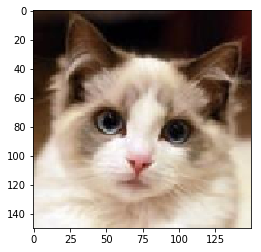


可视化类激活热力图


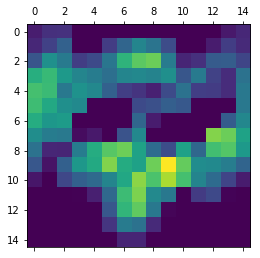

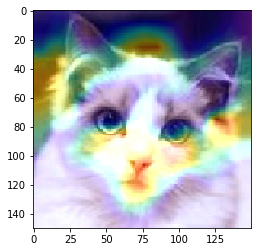

In [11]:
#图像分类预测
print('\n==============================================')
print('图像分类预测')    
predict_images(model,[test_img_path],test_gen,img_width=img_width,img_height=img_height)
##可视化类激活热力图
print('\n==============================================')
print('可视化类激活热力图')
visualizer_heatmap(model,test_img_path,last_conv_layer_name,target_size=(img_height,img_width))

# 实验2